In [8]:
%matplotlib inline


SET-UP: Training a Classifier with PyTorch
==================================

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
mytrainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
mytestloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [11]:
iter(mytrainloader).next()

[tensor([[[[ 0.9216,  0.8824,  0.8824,  ...,  0.6784,  0.6000,  0.4353],
           [ 0.8196,  0.8118,  0.8275,  ...,  0.4275,  0.3333,  0.2471],
           [ 0.7255,  0.7412,  0.7725,  ...,  0.2157,  0.1137, -0.0353],
           ...,
           [ 0.9686,  0.9608,  0.9608,  ...,  0.8196,  0.6235,  0.3882],
           [ 0.9529,  0.9843,  0.9686,  ...,  0.8980,  0.7412,  0.5059],
           [ 0.8980,  0.7412,  0.8039,  ...,  0.8824,  0.2314,  0.1294]],
 
          [[ 0.6000,  0.5686,  0.5608,  ...,  0.3961,  0.3255,  0.1686],
           [ 0.5059,  0.4980,  0.5137,  ...,  0.2157,  0.1216,  0.0275],
           [ 0.4275,  0.4510,  0.4824,  ...,  0.0745, -0.0353, -0.1843],
           ...,
           [ 0.7176,  0.7490,  0.7961,  ...,  0.5608,  0.4039,  0.1686],
           [ 0.6941,  0.7725,  0.7961,  ...,  0.6392,  0.5137,  0.2784],
           [ 0.6157,  0.5137,  0.5922,  ...,  0.5922, -0.0039, -0.1059]],
 
          [[ 0.1843,  0.1451,  0.1373,  ...,  0.0353, -0.0353, -0.1843],
           [ 

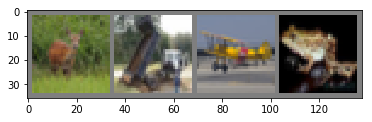

 deer truck plane  frog


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
mydataiter = iter(mytrainloader)
myimages, mylabels = mydataiter.next()

# show images
imshow(torchvision.utils.make_grid(myimages))
# print labels
print(' '.join('%5s' % classes[mylabels[j]] for j in range(4)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mynet = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [14]:
import torch.optim as optim

mycriterion = nn.CrossEntropyLoss()
myoptimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [15]:
%%time

def train(trainloader):

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            myoptimizer.zero_grad()

            # forward + backward + optimize
            outputs = mynet(inputs)
            loss = mycriterion(outputs, labels)
            loss.backward()
            myoptimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    
    return outputs

myoutputs = train(mytrainloader)

[1,  2000] loss: 2.169
[1,  4000] loss: 1.836
[1,  6000] loss: 1.670
[1,  8000] loss: 1.571
[1, 10000] loss: 1.492
[1, 12000] loss: 1.445
[2,  2000] loss: 1.399
[2,  4000] loss: 1.360
[2,  6000] loss: 1.349
[2,  8000] loss: 1.330
[2, 10000] loss: 1.314
[2, 12000] loss: 1.293
Finished Training
CPU times: user 5min 8s, sys: 16.4 s, total: 5min 24s
Wall time: 2min 18s


In [16]:
myoutputs

tensor([[ 2.7019e+00,  7.9799e+00, -1.8078e+00, -2.5281e+00, -1.2554e+00,
         -3.3541e+00, -2.1181e+00, -3.9752e+00,  3.3686e-01,  4.5768e+00],
        [-2.1709e+00, -3.5117e+00,  2.0542e+00,  2.9601e+00,  3.6718e+00,
          2.9448e+00,  3.0338e+00,  1.6017e+00, -4.5641e+00, -4.0991e+00],
        [ 2.8837e-03,  2.7481e-01,  9.2177e-01,  4.1888e-01,  9.3850e-01,
          1.7630e-01, -7.3045e-01,  1.1680e+00, -1.5500e+00, -3.3855e-01],
        [-5.2057e-01, -1.8753e+00,  1.6234e+00,  8.3775e-01,  7.7711e-01,
          4.0697e-01,  2.1147e-01, -4.7989e-01,  1.3926e-01, -2.3924e-02]],
       grad_fn=<AddmmBackward>)

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the testset and compare the predictions to the ground truth.


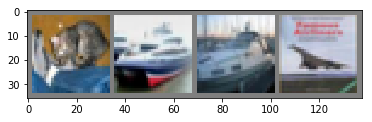

GroundTruth:    cat  ship  ship plane
Predicted  :    cat   car   car plane


In [17]:
mydataiter = iter(mytestloader)
myimages, mylabels = mydataiter.next()
myoutputs = mynet(myimages)
_, mypredicted = torch.max(myoutputs, 1)

# print images
imshow(torchvision.utils.make_grid(myimages))
print('GroundTruth: ', ' '.join('%5s' % classes[mylabels[j]] for j in range(4)))
print('Predicted  : ', ' '.join('%5s' % classes[mypredicted[j]] for j in range(4)))

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



Now, let's look at how the network performs on the entire dataset.

In [18]:
%%time

def getAccuracy(testloader):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = mynet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        correct / total * 100.))
    return correct / total * 100.
    
myaccuracy = getAccuracy(mytestloader)

Accuracy of the network on the 10000 test images: 54 %
CPU times: user 10.8 s, sys: 944 ms, total: 11.8 s
Wall time: 7.13 s


While those results are far from perfect (we will try to make them better in the next exercises), they still look better than random chance, which is 10% accuracy (randomly picking a class out of 10 classes).
It looks like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [19]:
%%time

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in mytestloader:
        images, labels = data
        outputs = mynet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 72 %
Accuracy of  bird : 44 %
Accuracy of   cat : 32 %
Accuracy of  deer : 48 %
Accuracy of   dog : 55 %
Accuracy of  frog : 70 %
Accuracy of horse : 54 %
Accuracy of  ship : 52 %
Accuracy of truck : 59 %
CPU times: user 10.1 s, sys: 864 ms, total: 11 s
Wall time: 5.71 s


EXERCISE 1: Supervised Learning & Learning Curves
===========================================

Now, let's build a first learning curve to see how the classifier's accuracy improves with the amount of data that is used to train it. To do that, we will add data progressively, batch after after, and plot the distribution of the accuracy vs. the number of records used for training. 

In [20]:
%run ActiveLearningClass.ipynb

Network's weights reinitialized
Training for 2000 samples:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 30.56%
Network's weights reinitialized
Training for 4000 samples:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 33.46%
Network's weights reinitialized
Training for 6000 samples:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 37.35%
Network's weights reinitialized
Training for 8000 samples:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 36.5%
Network's weights reinitialized
Training for 10000 samples:
Finished Training
GroundTruth:    cat
Predicted:   bird
Accuracy of the network on the 10000 test images: 34.43%


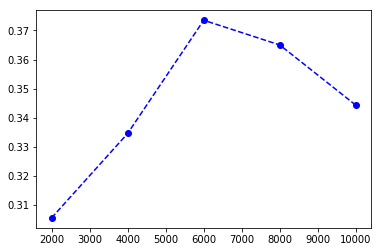

CPU times: user 19min 17s, sys: 1min 33s, total: 20min 50s
Wall time: 11min 53s


In [21]:
%%time

num_steps = 5     # <---- Play with those values. CIFAR-10 has 50,000 records for training, and 10,000 for testing
maximum = 10000   # <----
nps = int(maximum / num_steps)

myActiveStrategy = ActiveStrategy(mynet, nsteps=num_steps)

myActiveStrategy.verbose = False

myActiveStrategy.init_loaders()
myActiveStrategy.incremental_supervised()
mySupervised = myActiveStrategy.run_experiment(num_steps, maximum)
    
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised, '--b', marker="o")
plt.show()

As expected, the accuracy increases (overall) when more training data is added to train the model. 

QUESTION: What additional experiment(s) would you run to gain more understanding of the training set? What is the purpose of running such an experiment?
* Different samples to generate a band of accuracy per training sample size; gives you an idea of what the confidence interval is per sample size.

The question now is, can we do better? That's the question that Active Learning is trying to address...

In the next exercise, we will start with the easiest, most intuitive Active Learning strategy: confidence-level.


EXERCISE 2: Uncertainty-Based Strategies
===================================

Pooling Approach with Uncertainty-Based Strategy
------------------------------------------------------------

Let's start with the very first loop. We will select go through the following steps: 
1. We will select the first training set randomly.
2. We will train the model with that sample.
3. We will use the trained model for inferrence on the rest of the dataset.
4. We will select the 'nps' records with the lowest confidence and retrain the model with it.

Below, we perfect step 1. and 2.:

In [23]:
%%time
import random

unlabeled = [i for i in range(len(trainset))]
labeled   = []

to_be_labeled = random.sample(unlabeled, nps) # generate a random sample of the data, size nps (defined previously)
to_be_labeled_set = set(to_be_labeled)

unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update the unlabeled array once you defined to_be_labeled

myActiveStrategy.run_one(to_be_labeled)

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 25.36%
CPU times: user 1min 56s, sys: 8.26 s, total: 2min 4s
Wall time: 1min


In [33]:
print(len(to_be_labeled))
print(len(unlabeled))

4000
46000


Let's start with the very first loop. We will select go through the following steps: 
1. We will select the first training set randomly.
2. We will train the model with that sample.
3. We will use the train model for inferrence on the rest of the dataset.

We just trained the model using a random sample of size 'nps' (the size we choose for each step), to initialize our Active Learning process.

Now, let's move on to step 3. and 4.:

In [26]:
myResults = myActiveStrategy.infer(unlabeled)
# myResults[:10]

# Below, we update the to_be_labeled and unlabeled arrays, in preparation for the next loop...
# the strategy is to select the records that were inferred with the lowest confidence in the previous loop...
sorted_by_conf = sorted(myResults, key=lambda x: x[3])[:2000] # fill here; remember that the size of the array will be 'nps'

# update to_be_labeled:
to_be_labeled.extend([row[0] for row in sorted_by_conf])
to_be_labeled_set = set(to_be_labeled)

unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

# And run one more loop...
accuracy = myActiveStrategy.run_one(to_be_labeled)

Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 25.88%


In [28]:
myResults[:10]

[[0,
  'frog',
  'frog',
  tensor(0.5781),
  array([0.00751252, 0.02203998, 0.04192598, 0.08358631, 0.09015553,
         0.1432145 , 0.5781312 , 0.02007812, 0.00339432, 0.00996149],
        dtype=float32)],
 [1,
  'truck',
  'truck',
  tensor(0.4077),
  array([0.09611287, 0.2513873 , 0.05105133, 0.0246595 , 0.00578742,
         0.01846184, 0.01481133, 0.02029133, 0.10975036, 0.40768683],
        dtype=float32)],
 [2,
  'truck',
  'truck',
  tensor(0.3414),
  array([0.04747928, 0.10403188, 0.07348592, 0.08434021, 0.05827534,
         0.06887344, 0.06713587, 0.12380801, 0.03121658, 0.34135345],
        dtype=float32)],
 [3,
  'deer',
  'frog',
  tensor(0.4890),
  array([0.00711665, 0.01698517, 0.07723261, 0.07661139, 0.14896092,
         0.14664124, 0.48901328, 0.02484221, 0.00359232, 0.00900425],
        dtype=float32)],
 [4,
  'car',
  'truck',
  tensor(0.5538),
  array([0.05610464, 0.16053149, 0.04199112, 0.02068362, 0.01706747,
         0.02045746, 0.01192112, 0.03864058, 0.07875886,

In [18]:
myResultsSorted = sorted(myResults, key=lambda x: x[3])[:2000]
print(len(myResultsSorted))
myResultsSorted[:10]

2000


[[29247,
  'cat',
  'horse',
  tensor(0.1199),
  array([0.11331826, 0.10128255, 0.10236096, 0.10150664, 0.11639684,
         0.07161216, 0.09667381, 0.11988647, 0.07685285, 0.1001094 ],
        dtype=float32)],
 [15659,
  'cat',
  'cat',
  tensor(0.1235),
  array([0.12215959, 0.12140635, 0.11389454, 0.12347462, 0.05940158,
         0.1098175 , 0.05431493, 0.10453553, 0.11236259, 0.07863272],
        dtype=float32)],
 [5808,
  'dog',
  'plane',
  tensor(0.1244),
  array([0.12436724, 0.11198641, 0.09641605, 0.11983203, 0.08800576,
         0.06851987, 0.08075901, 0.11359534, 0.07659027, 0.11992799],
        dtype=float32)],
 [4832,
  'ship',
  'bird',
  tensor(0.1250),
  array([0.11327136, 0.10086782, 0.12503335, 0.123506  , 0.0848975 ,
         0.11973836, 0.06628142, 0.07261097, 0.09344246, 0.10035075],
        dtype=float32)],
 [49408,
  'cat',
  'ship',
  tensor(0.1252),
  array([0.11924184, 0.12165697, 0.07835262, 0.11747256, 0.05732012,
         0.07424808, 0.06623078, 0.11588085, 

Now, let's implement the whole process and run all the loops.

In [19]:
%%time

def confidenceAL(nsteps, stepSize):
    
    results = []
    
    unlabeled = [i for i in range(len(trainset))]
    labeled   = []
    
    to_be_labeled = random.sample(unlabeled, stepSize)
    to_be_labeled_set = set(to_be_labeled)
    unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled))
    
    myres = myActiveStrategy.run_one(to_be_labeled)
    results.append(myres)
    
    for n in range(1, nsteps):
        # Fill algorithm here getting inspiration from the previous exercise
        myResults = myActiveStrategy.infer(unlabeled)
        sorted_by_conf = sorted(myResults, key=lambda x: x[3])[:stepSize] # fill here; remember that the size of the array will be 'nps'

        # update to_be_labeled:
        to_be_labeled.extend([row[0] for row in sorted_by_conf])
        to_be_labeled_set = set(to_be_labeled)
        unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

        myres = myActiveStrategy.run_one(to_be_labeled)
        results.append(myres)
        
    return results
    
myConfidenceAL = confidenceAL(num_steps, nps)

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:   deer
Accuracy of the network on the 10000 test images: 27.64%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 30.37%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 28.89%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:    cat
Predicted:   ship
Accuracy of the network on the 10000 test images: 35.5%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 33.02%
CPU times: user 30min 47s, sys: 1min 29s, total: 32min 16s
Wall time: 6min 29s


Aren't you curious to know how good those results are? We can now compare the learning curve that we obtain with the one we got for the supervised approach.

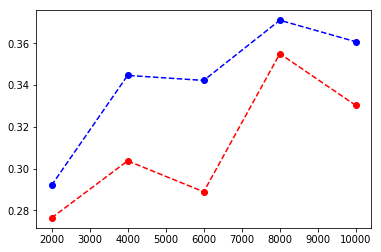

In [20]:
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,   '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL, '--r',
         marker="o")

Now, the ActiveStrategy Class already comes with a method you can use to "onboard" any querying strategy you would like. Here is how it works:


Implement the confidence level based strategy using this method.
Then, run the process; you can move on to the next exercise while training is in progress here.

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 25.14%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    car
Accuracy of the network on the 10000 test images: 24.42%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 28.95%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 35.88%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 32.12%
CPU times: user 31min 5s, sys: 1min 30s, total: 32min 35s
Wall time: 6min 33s


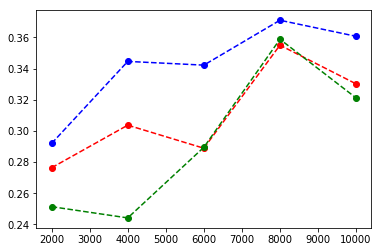

In [21]:
%%time

def update_function(inferred_res, nRec):
    ranked = sorted(inferred_res, key=lambda x: x[3])[:nRec] # Sort and select the best nRec elements
    selected = [rec[0] for rec in ranked]
    
    return selected
    
myConfidenceAL2 = myActiveStrategy.run_ConfidenceAL(update_function, num_steps, maximum)
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL,  '--r',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--g',
         marker="o")

Now, for our strategy, we have been selecting the records for which the lowest confidence was observed in inferrence, assuming that these data points would be the ones that the model is the most confused about. While this is a sound strategy with a fairly clean dataset, in real life, it could lead to injecting more and more spam/noise into the training set.

To help, let's start by drawing the distribution of the confidence level for the last inferences we ran:

[0.5781311988830566, 0.40768682956695557, 0.3413534462451935, 0.48901328444480896, 0.5538435578346252, 0.430853933095932, 0.3185495138168335, 0.3120585083961487, 0.3443581461906433, 0.20962347090244293]
48000
CPU times: user 92 ms, sys: 12 ms, total: 104 ms
Wall time: 104 ms


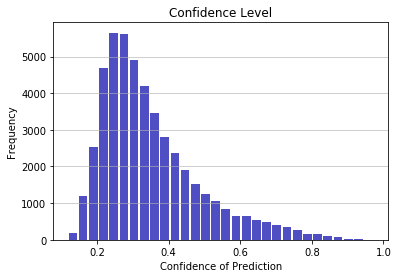

In [43]:
%%time

inferred_CL = [ c[3].item() for c in myResults ]
print(inferred_CL[:10])
print(len(inferred_CL))

n, bins, patches = plt.hist(x=inferred_CL, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Confidence of Prediction')
plt.ylabel('Frequency')
plt.title('Confidence Level')
maxfreq = n.max()

plt.ylim(top=(np.ceil(maxfreq / 10) * 10 * 1.05) if maxfreq % 10 else (maxfreq + 10) * 1.05)

QUESTION: Before moving on, discuss what a good choice for nps might be here (so far, we have taken that value arbitrarily). What experient would you design to automatically choose an optimal "nps" value. Please discuss.
* Very low confidence level might actually capture outliers or noise.
* You can see that there's a peak around 0.2 - 0.25, so might want to capture those first instead of starting from the very low confidence level.

A Better Confidence Level-Based Strategy
--------------------------------------------------

Implement an alternative confidence level-based strategy where very low confidence records get cut out, and where you selected the lowest confidence records from the "medium" confidence sample. Experiment with different cutoffs and compare the results.

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 27.42%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 21.17%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 29.58%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 30.55%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:    cat
Predicted:   bird
Accuracy of the network on the 10000 test images: 36.24%
CPU times: user 31min 1s, sys: 1min 28s, total: 32min 30s
Wall time: 6min 30s


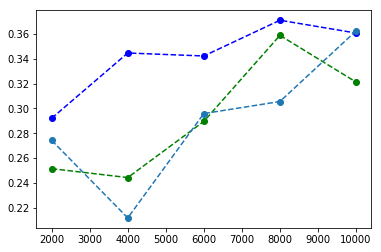

In [24]:
%%time

def update_CL_improved(inferred_res, nRec, nFilter=500): # <--- we can play with nFilter value later
    ranked = sorted(inferred_res, key=lambda x: x[3])[nFilter:]
    selected = [rec[0] for rec in ranked[:nRec]]
    
    return selected

myConfidenceAL3 = myActiveStrategy.run_ConfidenceAL(update_CL_improved, num_steps, maximum)
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--g',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL3, '--p',
         marker="o")

Optional Exercise:
----------------------
WARNING: THIS IS VERY LONG TO RUN!!! You're invited to try it after the session, or after you are done with the other steps.

Let's draw the final accuracy as a function of the 'nFilter' value:

In [ ]:
%%time

finalAccuracies = []
stepValues = [500, 1000, 2000, 5000] # <-- customize this to experiment different values
for nf in stepValues:
    print(">>>>> Running algorithm for {0}".format(nf))
    myAcc = # Fill here
    finalAccuracies.append(myAcc)

plt.plot(stepValues, [a[-1] for a in finalAccuracies] , '--b', marker="o")

QUESTION: What are the learning from the plot that you obtained? What further studies does this inspire to you?

Streaming Approach with Uncertainty-Based Strategy
---------------------------------------------------------------

Now, instead of a pooling approach, let's use a streaming approach. Instead of using a fixed number of records at each step, you can now use a rule; for instance, instead of selecting 'n' best records, use a threshold in confidence level. What are the benefits and challenges with each methodology?
* Benefit of selecting fixed number of records is that you are ingesting the same number of data points at each iteration, meaning you can rule out sample size from how it impacts the model performance.
* Using confidence level allows you to choose samples more specifically but less control over how many data points to use per iteration.

In [27]:
sorted(x for x in inferred_CL if x < 0.1)

[]

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 25.96%
Network's weights reinitialized
Training for 2361 records:
Finished Training
GroundTruth:    cat
Predicted:   deer
Accuracy of the network on the 10000 test images: 20.72%
Network's weights reinitialized
Training for 3629 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 24.18%
Network's weights reinitialized
Training for 4031 records:
Finished Training
GroundTruth:    cat
Predicted:   bird
Accuracy of the network on the 10000 test images: 20.67%
Network's weights reinitialized
Training for 4451 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 24.97%
CPU times: user 23min 17s, sys: 1min 12s, total: 24min 30s
Wall time: 5min 14s


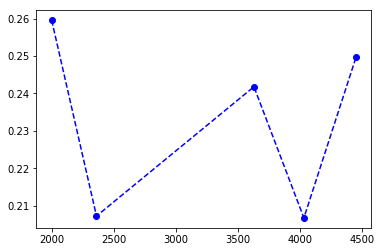

In [28]:
%%time

def update_streaming(inferred_res, threshold=0.15):
    next_loop = sorted(x[0] for x in inferred_res if x[3] < threshold)
    
    return next_loop
    
myStreamingAL, myStepSizes = myActiveStrategy.run_StreamingAL(update_streaming, num_steps, maximum)
plt.plot(myStepSizes, myStreamingAL , '--b', marker="o")

Now, let's define the threshold based a certain percentile value for the inferred array (in other term, we choose what percentage of the data we keep at each step). Does that remind you of something? :-)

In [44]:
inferred_CL[:10]

[0.5781311988830566,
 0.40768682956695557,
 0.3413534462451935,
 0.48901328444480896,
 0.5538435578346252,
 0.430853933095932,
 0.3185495138168335,
 0.3120585083961487,
 0.3443581461906433,
 0.20962347090244293]

In [30]:
thresh = np.percentile(inferred_CL, 5)

In [45]:
np.percentile(inferred_CL, 5)

0.18863599747419357

In [31]:
sorted(x for x in inferred_CL if x < thresh)[:10]

[0.11988647282123566,
 0.12347462028265,
 0.12436723709106445,
 0.12503334879875183,
 0.12519676983356476,
 0.12603679299354553,
 0.12605974078178406,
 0.1267474889755249,
 0.12676221132278442,
 0.12677903473377228]

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 22.43%
0.13972185999155043
Network's weights reinitialized
Training for 4400 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 23.47%
0.19081770330667497
Network's weights reinitialized
Training for 6680 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 27.78%
0.18751047998666764
Network's weights reinitialized
Training for 8846 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 33.21%
0.178490037471056


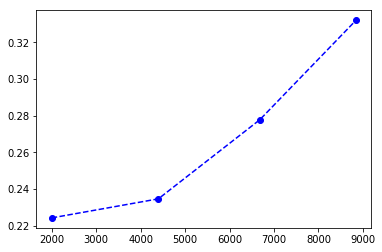

In [32]:
def update_streaming_perc(inferred_res, threshold=5): # <-- here, threshold is the amount of data we want to keep
    # Using the np.percentile function, fill the function
    perc = np.percentile([x[3] for x in inferred_res], threshold)
    print(perc)
    next_loop = sorted(x[0] for x in inferred_res if x[3] < perc)
    
    return next_loop
    
myStreamingAL2, myStepSizes2 = myActiveStrategy.run_StreamingAL(update_streaming_perc, num_steps, maximum)
plt.plot(myStepSizes2, myStreamingAL2 , '--b', marker="o")

QUESTION: In the code above, a major approximation was made. Do you see what it is, and how would you change it?

Margin Sampling-Based Strategy
---------------------------------------

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 26.48%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 27.31%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 29.01%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 35.5%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:    cat
Predicted:    car
Accuracy of the network on the 10000 test images: 28.75%
CPU times: user 31min 11s, sys: 1min 47s, total: 32min 58s
Wall time: 6min 56s


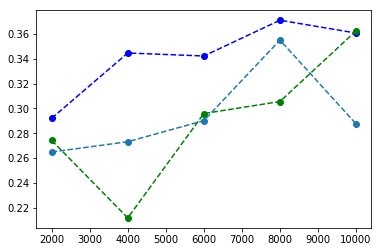

In [35]:
%%time
import operator

# Explain what this function does...
def update_margin(inferred_res, nRec):
    for k in range(len(inferred_res)):
        # Margin difference in confidence between the most confident classes
#         inferred_res[k].extend(zip(*sorted(enumerate(inferred_res[k]), key=operator.itemgetter(1)))[0][-2:])
        inferred_res[k].extend(list(zip(*sorted(enumerate(inferred_res[k][4]), key=operator.itemgetter(1))))[1][-2:])
    
#     ranked = sorted(inferred_res, key=lambda x: x[5] - x[4], reverse=False)[:nRec]
    ranked = sorted(inferred_res, key=lambda x: x[6] - x[5], reverse=False)[:nRec] # margin low to high
    selected = [rec[0] for rec in ranked]
    
    return selected

myConfidenceAL4 = myActiveStrategy.run_ConfidenceAL(update_margin, num_steps, maximum)
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL3, '--g',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL4, '--p',
         marker="o")

Now, let's try a different type of strategy, called:


EXERCISE 3: Query-By-Committee Strategies
=====================================

For Query-By-Committee strategies, we will take an approach similar to ensemble methods in Supervised Learning.
Instead of training only one classifier, we will train several algorithms, and decide on which data to select for the next loop based on the level of disagreement between them.

For our case, we could use several variations (with slightly different hyperparameters) of the same model and start by initializing different similar classifiers.

Using the code below, try to run a QbC strategy by making the necessary adjustements on the model. What changes are necessary, and does the model actually need to be modified? Please comment...

In [37]:
%%time

unlabeled = [i for i in range(len(trainset))]
labeled   = []

to_be_labeled = random.sample(unlabeled, nps)
unlabeled = [i for i in range(len(unlabeled)) if i not in to_be_labeled]

myAccuracy1 = myActiveStrategy.run_one(to_be_labeled)
myResults1  = myActiveStrategy.infer(unlabeled)
myAccuracy2 = myActiveStrategy.run_one(to_be_labeled)
myResults2  = myActiveStrategy.infer(unlabeled)
myAccuracy3 = myActiveStrategy.run_one(to_be_labeled)
myResults3  = myActiveStrategy.infer(unlabeled)

disagreement = []

for r in range(len(unlabeled)):
    dis = 0
    if myResults1[r][2] != myResults2[r][2]:
        dis += 1
    if myResults2[r][2] != myResults3[r][2]:
        dis += 1
    if myResults1[r][2] != myResults3[r][2]:
        dis += 1
    disagreement.append(dis)
    
print(disagreement[0:10])
    
print("No        disagreements: {0} \n".format(disagreement.count(0)), 
      "One (1)   disagreement : {0} \n".format(disagreement.count(1)), 
      "Two (2)   disagreements: {0} \n".format(disagreement.count(2)), 
      "Three (3) disagreements: {0} \n".format(disagreement.count(3)))

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 24.98%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 18.13%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 24.4%
[2, 3, 0, 2, 2, 3, 3, 3, 3, 2]
No        disagreements: 3191 
 One (1)   disagreement : 0 
 Two (2)   disagreements: 24755 
 Three (3) disagreements: 20054 

CPU times: user 13min 10s, sys: 44.6 s, total: 13min 55s
Wall time: 3min 12s


In [50]:
[i for i in zip(myResultsSorted, disagreement)][:5]

[([29247,
   'cat',
   'horse',
   tensor(0.1199),
   array([0.11331826, 0.10128255, 0.10236096, 0.10150664, 0.11639684,
          0.07161216, 0.09667381, 0.11988647, 0.07685285, 0.1001094 ],
         dtype=float32)],
  2),
 ([15659,
   'cat',
   'cat',
   tensor(0.1235),
   array([0.12215959, 0.12140635, 0.11389454, 0.12347462, 0.05940158,
          0.1098175 , 0.05431493, 0.10453553, 0.11236259, 0.07863272],
         dtype=float32)],
  3),
 ([5808,
   'dog',
   'plane',
   tensor(0.1244),
   array([0.12436724, 0.11198641, 0.09641605, 0.11983203, 0.08800576,
          0.06851987, 0.08075901, 0.11359534, 0.07659027, 0.11992799],
         dtype=float32)],
  0),
 ([4832,
   'ship',
   'bird',
   tensor(0.1250),
   array([0.11327136, 0.10086782, 0.12503335, 0.123506  , 0.0848975 ,
          0.11973836, 0.06628142, 0.07261097, 0.09344246, 0.10035075],
         dtype=float32)],
  2),
 ([49408,
   'cat',
   'ship',
   tensor(0.1252),
   array([0.11924184, 0.12165697, 0.07835262, 0.11747256, 

In [53]:
[x[0] for x in [i for i in zip(myResultsSorted, disagreement)][:5]]

[[29247,
  'cat',
  'horse',
  tensor(0.1199),
  array([0.11331826, 0.10128255, 0.10236096, 0.10150664, 0.11639684,
         0.07161216, 0.09667381, 0.11988647, 0.07685285, 0.1001094 ],
        dtype=float32)],
 [15659,
  'cat',
  'cat',
  tensor(0.1235),
  array([0.12215959, 0.12140635, 0.11389454, 0.12347462, 0.05940158,
         0.1098175 , 0.05431493, 0.10453553, 0.11236259, 0.07863272],
        dtype=float32)],
 [5808,
  'dog',
  'plane',
  tensor(0.1244),
  array([0.12436724, 0.11198641, 0.09641605, 0.11983203, 0.08800576,
         0.06851987, 0.08075901, 0.11359534, 0.07659027, 0.11992799],
        dtype=float32)],
 [4832,
  'ship',
  'bird',
  tensor(0.1250),
  array([0.11327136, 0.10086782, 0.12503335, 0.123506  , 0.0848975 ,
         0.11973836, 0.06628142, 0.07261097, 0.09344246, 0.10035075],
        dtype=float32)],
 [49408,
  'cat',
  'ship',
  tensor(0.1252),
  array([0.11924184, 0.12165697, 0.07835262, 0.11747256, 0.05732012,
         0.07424808, 0.06623078, 0.11588085, 

Now, let's implement use the previous approach as our querying strategy. Note that this takes a long time to run, so you're encouraged that you reduce your 'num_steps' and 'maximum' variables.

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 25.0%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 23.73%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 28.23%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 26.44%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 28.11%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on

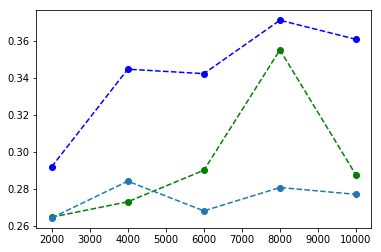

In [52]:
def QbCAL(nsteps, stepSize):
    
    results = []
    
    unlabeled = [i for i in range(len(trainset))]
    labeled   = []

    # Randomly sample what is to be labeled first...
    to_be_labeled = random.sample(unlabeled, stepSize)
    unlabeled = [i for i in range(len(unlabeled)) if i not in to_be_labeled]
    
    for n in range(0, nsteps):
        # Fill the function by following the same logic that previously within a loop
        myAccuracy1 = myActiveStrategy.run_one(to_be_labeled)
        myResults1  = myActiveStrategy.infer(unlabeled)
        myAccuracy2 = myActiveStrategy.run_one(to_be_labeled)
        myResults2  = myActiveStrategy.infer(unlabeled)
        myAccuracy3 = myActiveStrategy.run_one(to_be_labeled)
        myResults3  = myActiveStrategy.infer(unlabeled)
        
        disagreement = []

        for r in range(len(unlabeled)):
            dis = 0
            if myResults1[r][2] != myResults2[r][2]:
                dis += 1
            if myResults2[r][2] != myResults3[r][2]:
                dis += 1
            if myResults1[r][2] != myResults3[r][2]:   
                dis += 1
            disagreement.append(dis)
        
        sorted_by_disagree = sorted(zip(myResults1, disagreement), key=lambda x: x[1], reverse=True)[:stepSize] # fill here; remember that the size of the array will be 'nps'

        # update to_be_labeled:
        to_be_labeled.extend([x[0] for x in [row[0] for row in sorted_by_disagree]])
        to_be_labeled_set = set(to_be_labeled)
        unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

        myres = myActiveStrategy.run_one(to_be_labeled)
        results.append(myres)        
        
    return results
    
myQbCAL = QbCAL(num_steps, nps)

plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL4, '--g',
         [nps*i for i in range(1, num_steps + 1)], myQbCAL,         '--p',
         marker="o")

Observations:
* QbC is a lot more stable, but does not result in significant improvements like the other methodologies.

EXERCISE 4: Build-Your-Own Strategy
===============================

Now, using what you have learned, develop the best querying strategy you can!